# Good Crop Bad Crop

### Mask creation

Initial mask creation done manually with the possibility of creating masks using a tool in the future. (One field mask creation)

Issues:
- Different fields will have different pixel counts, need to compress last fields/expand small fields.  Suggestion: Analyse fields across dataset and determine average size in pixels, initially just use chosen field size

In [1]:
#imports
from PIL import Image
import matplotlib.pyplot as plt
from matplotlib import image
import numpy as np
import glob
import pandas as pd
from datetime import datetime
import copy
from matplotlib import cm
import matplotlib.dates as mdates
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RepeatedStratifiedKFold, GridSearchCV
from sklearn.metrics import mean_squared_error, make_scorer
import seaborn as sns

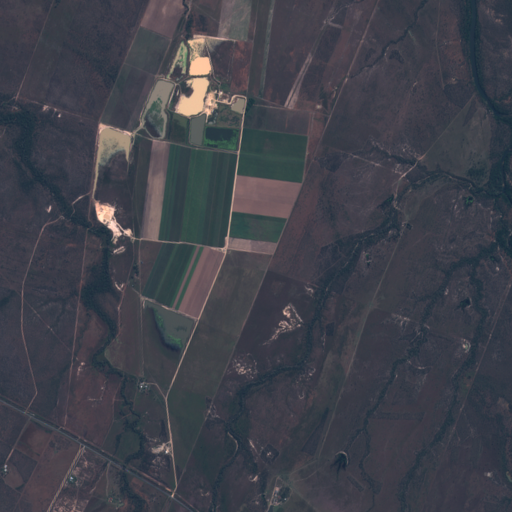

In [2]:
tile_x = 5120
tile_y = 3584
band = 'TCI' #photo
time_period = '2019-07-20'
TCI_filename = f"./satelite_data/Phase02DataDelivery/sugarcanetiles/{tile_x}-{tile_y}-{band}-{time_period}.png"
#mask_filename = f"./satelite_data/Phase02DataDelivery/masks/mask-x{tile_x}-y{tile_y}.png"

#np.array(TCI_image.resize((100, 100)).getdata())
TCI_image = Image.open(TCI_filename)
TCI_image

In [3]:
#now that we have a mask, let us load all of the related image, and store them in a dataframe with each row being a date

location_path = f"./satelite_data/Phase02DataDelivery/sugarcanetiles/{tile_x}-{tile_y}-{band}*.png"
location_times = glob.glob(location_path)

for i in range(0,len(location_times)):
    location_times[i] = location_times[i][-14:-4]
    

location_times.sort(reverse=True)
location_times

['2019-08-09',
 '2019-07-30',
 '2019-07-20',
 '2019-06-30',
 '2019-06-20',
 '2019-06-10',
 '2019-05-21',
 '2019-05-11',
 '2019-05-01',
 '2019-04-21',
 '2019-04-11',
 '2019-03-12',
 '2019-03-02',
 '2019-02-20',
 '2019-01-21',
 '2019-01-01',
 '2018-12-02',
 '2018-11-22',
 '2018-11-12',
 '2018-11-02',
 '2018-10-23',
 '2018-10-03',
 '2018-09-13',
 '2018-09-03',
 '2018-08-24',
 '2018-08-14',
 '2018-08-04',
 '2018-07-25',
 '2018-07-15',
 '2018-07-05',
 '2018-06-25',
 '2018-06-15',
 '2018-06-05',
 '2018-05-26',
 '2018-05-06',
 '2018-04-26',
 '2018-04-16',
 '2018-03-17',
 '2018-02-15',
 '2018-01-26',
 '2018-01-06',
 '2017-12-27',
 '2017-12-17',
 '2017-12-07',
 '2017-11-27',
 '2017-11-17',
 '2017-11-07',
 '2017-10-28',
 '2017-10-08',
 '2017-09-28',
 '2017-09-18',
 '2017-09-08',
 '2017-08-19',
 '2017-08-09',
 '2017-07-30',
 '2017-07-20',
 '2017-07-10',
 '2017-06-20',
 '2017-05-31',
 '2017-05-21',
 '2017-05-11',
 '2017-05-01',
 '2017-04-11',
 '2017-04-01',
 '2017-03-12',
 '2017-03-02',
 '2017-02-

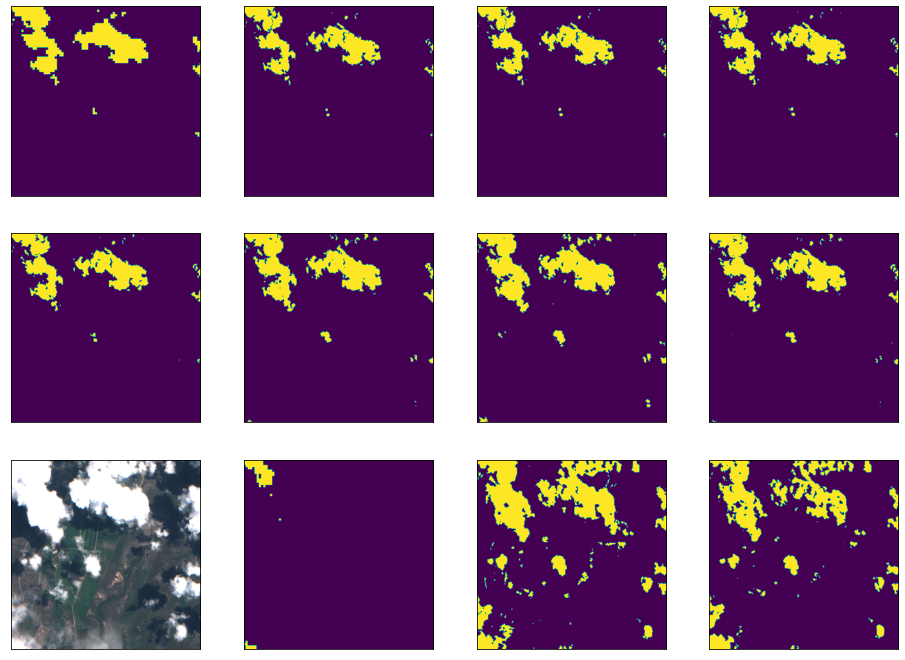

In [4]:
# Data exploration for detecting clouds
# Based on visualisation:
# "white" of cloud - colour intensity > 0.36
# "shadow" of cloud - 

     
def norm_image(vimage):
    vimage_min = np.min(vimage)
    vimage_max = np.max(vimage)
    return (vimage-vimage_min)/(vimage_max-vimage_min)
    
w = 10
h = 10
fig = plt.figure(figsize=(16, 16))
columns = 4
rows = 4

Cirrus_path = f"./satelite_data/Phase02DataDelivery/sugarcanetiles/{tile_x}-{tile_y}-B09-2017-02-20.png"

for i in range(1,13):
    ax = fig.add_subplot(rows, columns, i)
    ax.set_xticks([])
    ax.set_yticks([])
    if(i == 9):
        R_image = image.imread(f"./satelite_data/Phase02DataDelivery/sugarcanetiles/{tile_x}-{tile_y}-TCI-2017-02-20.png")
        plt.imshow(R_image)
    else:
        R_image = image.imread(f"./satelite_data/Phase02DataDelivery/sugarcanetiles/{tile_x}-{tile_y}-B{i:02}-2017-02-20.png")
        Cirrus_image = image.imread(Cirrus_path)
        plt.imshow(np.minimum(np.maximum(norm_image(R_image)-0.5,0)*1000,1))

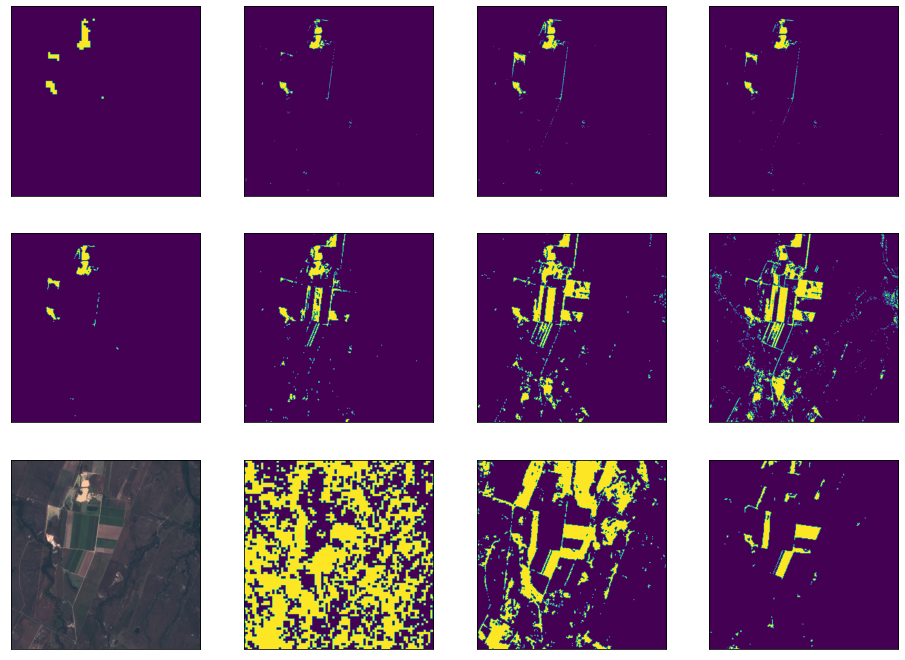

In [5]:
# Data exploration for detecting clouds
# Based on visualisation:
# "white" of cloud - colour intensity > 0.36
# "shadow" of cloud - 

        
w = 10
h = 10
fig = plt.figure(figsize=(16, 16))
columns = 4
rows = 4

Cirrus_path = f"./satelite_data/Phase02DataDelivery/sugarcanetiles/{tile_x}-{tile_y}-B09-2019-07-20.png"

    
for i in range(1,13):
    ax = fig.add_subplot(rows, columns, i)
    ax.set_xticks([])
    ax.set_yticks([])
    if(i == 9):
        R_image = image.imread(f"./satelite_data/Phase02DataDelivery/sugarcanetiles/{tile_x}-{tile_y}-TCI-2019-07-20.png")
        
        plt.imshow(R_image)
    else:
        R_image = image.imread(f"./satelite_data/Phase02DataDelivery/sugarcanetiles/{tile_x}-{tile_y}-B{i:02}-2019-07-20.png")
        Cirrus_image = image.imread(Cirrus_path)
        plt.imshow(np.minimum(np.maximum(norm_image(R_image)-0.475,0)*1000,1))

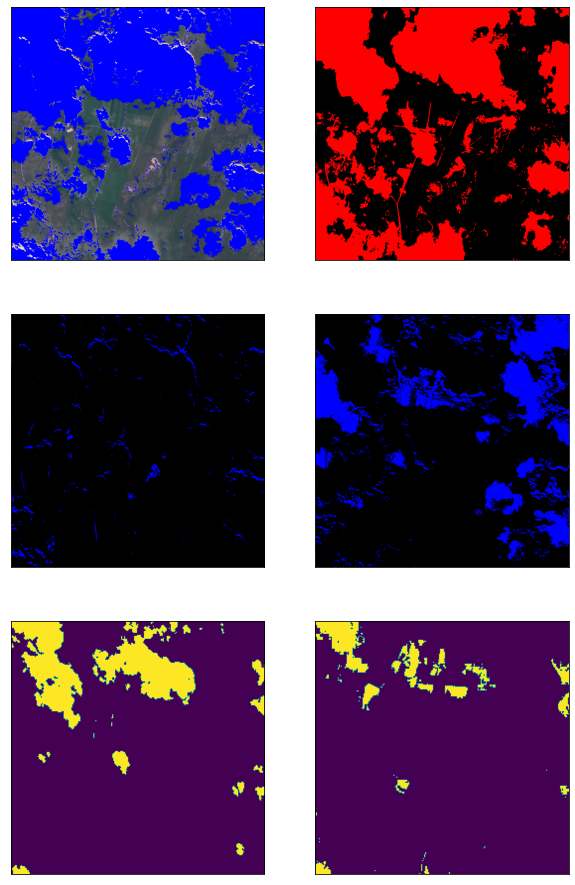

In [6]:
# Data exploration for detecting clouds
# Based on visualisation:
# "white" of cloud - colour intensity > 0.36
# "shadow" of cloud - 

def detect_cloud(pixel):
    red = pixel[0]
    green = pixel[1]
    blue = pixel[2]
    
    intensity = pixel.mean()
    saturation = (pixel.max() - pixel.min()) / (pixel.max() + pixel.min())

    red_blue_dif = red - blue
    if(image_file[i, j,0] > 0.45):
        if (red - blue) > 0.07:
            return False
        else:
            return True
    elif( green - blue ) < -0.04:
        return True
    else:
        return False
        
w = 10
h = 10
fig = plt.figure(figsize=(10, 16))
columns = 2
rows = 3

file_path = f"./satelite_data/Phase02DataDelivery/sugarcanetiles/{tile_x}-{tile_y}-TCI-2017-02-20.png"
NIR_path = f"./satelite_data/Phase02DataDelivery/sugarcanetiles/{tile_x}-{tile_y}-B08-2017-02-20.png"
R_path = f"./satelite_data/Phase02DataDelivery/sugarcanetiles/{tile_x}-{tile_y}-B04-2017-02-20.png"
G_path = f"./satelite_data/Phase02DataDelivery/sugarcanetiles/{tile_x}-{tile_y}-B03-2017-02-20.png"
Cirrus_path = f"./satelite_data/Phase02DataDelivery/sugarcanetiles/{tile_x}-{tile_y}-B09-2017-02-20.png"
B07_path = f"./satelite_data/Phase02DataDelivery/sugarcanetiles/{tile_x}-{tile_y}-B07-2017-02-20.png"

# file_path = f"./satelite_data/Phase02DataDelivery/sugarcanetiles/{tile_x}-{tile_y}-TCI-2019-07-20.png"
# NIR_path = f"./satelite_data/Phase02DataDelivery/sugarcanetiles/{tile_x}-{tile_y}-B08-2019-07-20.png"
# R_path = f"./satelite_data/Phase02DataDelivery/sugarcanetiles/{tile_x}-{tile_y}-B04-2019-07-20.png"
# B07_path = f"./satelite_data/Phase02DataDelivery/sugarcanetiles/{tile_x}-{tile_y}-B07-2019-07-20.png"
# Cirrus_path = f"./satelite_data/Phase02DataDelivery/sugarcanetiles/{tile_x}-{tile_y}-B09-2019-07-20.png"

Cirrus_image = image.imread(Cirrus_path)

ax = fig.add_subplot(rows, columns, 1)
ax.set_xticks([])
ax.set_yticks([])
image_file = image.imread(file_path)
for i in range(1,512):
    for j in range(1,512):
        col = image_file[i, j]
        if(detect_cloud(np.array(col))):
            image_file[i, j,0] = 0
            image_file[i,j,2] = 1
            image_file[i,j,1] = 0
plt.imshow(image_file)

ax = fig.add_subplot(rows, columns, 2)
ax.set_xticks([])
ax.set_yticks([])
image_file = image.imread(file_path)
for i in range(1,512):
    for j in range(1,512):
        #if(bool_mask[i,j]):
        col = image_file[i, j]
        image_file[i, j,0] = np.array(col).mean()
        if(image_file[i, j,0] < 0.35 and Cirrus_image[i,j]<0.18):
            image_file[i, j,0] = 0
        else:
            image_file[i, j,0] = 1
        #print(np.array(col).mean())
        image_file[i,j,1] = 0.0
        image_file[i,j,2] = 0.0
plt.imshow(image_file)


ax = fig.add_subplot(rows, columns, 3)
ax.set_xticks([])
ax.set_yticks([])
image_file = image.imread(file_path)
for i in range(1,512):
    for j in range(1,512):
        #if(bool_mask[i,j]):
        col = np.array(image_file[i, j])
        red_blue_dif = (image_file[i,j,0] - image_file[i,j,2])
        if(red_blue_dif > 0.07):
            image_file[i, j,0] = 0
            image_file[i,j,2] = 1
            image_file[i,j,1] = 0
        else:
            image_file[i, j,0] = 0
            image_file[i,j,2] = 0
            image_file[i,j,1] = 0
plt.imshow(image_file)

ax = fig.add_subplot(rows, columns, 4)
ax.set_xticks([])
ax.set_yticks([])
image_file = image.imread(file_path)
for i in range(1,512):
    for j in range(1,512):
        #if(bool_mask[i,j]):
            col = np.array(image_file[i, j])
            green_blue_dif = (image_file[i,j,1] - image_file[i,j,2])
            if(green_blue_dif < -0.06):
                image_file[i, j,0] = 0
                image_file[i,j,2] = 1
                image_file[i,j,1] = 0
            else:
                image_file[i, j,0] = 0
                image_file[i,j,2] = 0
                image_file[i,j,1] = 0
plt.imshow(image_file)

ax = fig.add_subplot(rows, columns, 5)
ax.set_xticks([])
ax.set_yticks([])
# image_file = image.imread(file_path)
# plt.imshow(image_file)
#NIR_image = image.imread(NIR_path)
B07_image = image.imread(B07_path)
B07_image = np.minimum(np.maximum(norm_image(B07_image)-0.475,0)*1000,1)
#NDVI_image = (NIR_image - R_image)/(NIR_image + R_image)
#print(NDVI_image)
plt.imshow(B07_image)

ax = fig.add_subplot(rows, columns, 6)
ax.set_xticks([])
ax.set_yticks([])


def set_pixel(mask, i, j, thickness=7, val=1):
    mask[i,j] = val
#     for i_val in range(1,thickness):
#         pos_i = np.minimum(i_val+i,511)
#         neg_i = np.maximum(i_val-i,1)
#         for j_val in range(1,thickness):
#             pos_j = np.minimum(j_val+j,511)
#             neg_j = np.maximum(j_val-j,1)
#             mask[pos_i,pos_j] = val
#             mask[pos_i,neg_j] = val
#             mask[neg_i,pos_j] = val
#             mask[neg_i,neg_j] = val
            
cirrus_min = np.min(Cirrus_image)
cirrus_max = np.max(Cirrus_image)
#using B01 emphasises shadows
cirrus_emphasis = (Cirrus_image - R_image)/(Cirrus_image + R_image)

# print(np.min(cirrus_emphasis))
# print(np.max(cirrus_emphasis))
cloud_mask = np.zeros([512,512])
# image_file = image.imread(file_path)
# min_cirrus = np.array(Cirrus_image).min()
# max_cirrus = np.array(Cirrus_image).max()
# mean_cirrus = np.array(Cirrus_image).mean()

for i in range(1,512):
    for j in range(1,512):
#         if(Cirrus_image[i,j] <= 0.006):
#             set_pixel(cloud_mask, i, j)
        if(cirrus_emphasis[i,j] >= 0.1):
            set_pixel(cloud_mask, i, j)

plt.imshow(cloud_mask)

## Detect crop cycles (on a per pixel basis)

In [7]:
df = pd.DataFrame()

colour_names = ['R','G','B','A']

#check if a pixel is in a current crop batch or in a non-crop period (ie. is red)
#if it is in a non-crop period see if it is now green
#if it is now green set it to be in a crop period, increment the crop counter (label) for that pixel and set it to be in a current crop period
#if it is in a crop period see if it is now red
#if it is now red set it to be in a non-crop period

r_val=0
g_val=1
b_val=2

image_width = 512
image_height = 512
n = image_width*image_height

mask_filename = f"./satelite_data/{tile_x}-{tile_y}-SingleFieldMask.png"
#mask_filename = f"./satelite_data/Phase02DataDelivery/masks/mask-x{tile_x}-y{tile_y}.png"
mask_image = image.imread(mask_filename).reshape(512*512,4).T[3]
bool_mask = (mask_image == 1.0).reshape(512,512,)
unmasked_pixels = bool_mask[bool_mask].shape[0]
has_crop = np.zeros(unmasked_pixels)
crop_index = np.zeros(unmasked_pixels)
prev_dict = {"Crop Index": np.full((unmasked_pixels), -1, dtype=int)}
row_dict = dict()

#reverse time order, as the NDVI jump is higher in reverse
for time_period in location_times:
    print(f"Begin processing {time_period}")
    # add TCI
    file_path = f"./satelite_data/Phase02DataDelivery/sugarcanetiles/{tile_x}-{tile_y}-TCI-{time_period}.png"
    image_file = image.imread(file_path)
    ravel_pixels = np.array(image_file[bool_mask])
    #print(ravel_pixels.shape)
    
    #calc NDVI
    NIR_path = f"./satelite_data/Phase02DataDelivery/sugarcanetiles/{tile_x}-{tile_y}-B08-{time_period}.png"
    R_path = f"./satelite_data/Phase02DataDelivery/sugarcanetiles/{tile_x}-{tile_y}-B04-{time_period}.png"
    NIR_image = image.imread(NIR_path)
    R_image = image.imread(R_path)
    NDVI_image = (NIR_image - R_image)/(NIR_image + R_image)
    ndvi_pixels = np.array(NDVI_image[bool_mask].ravel())
    if 'NDVI Image' in prev_dict.keys():
        prev_ndvi = np.ravel(prev_dict["NDVI Image"])
    else:
        prev_ndvi = None
    
    row_dict = {'Time': datetime.strptime(time_period, '%Y-%m-%d'), 
                "Cloud Cover": np.full((unmasked_pixels), 0, dtype=int), 
                "End of Crop Cycle": np.full((unmasked_pixels), 0, dtype=int), 
                "Start of Crop Cycle": np.full((unmasked_pixels), 0, dtype=int), 
                "Image": image_file, 
                "NDVI Image": NDVI_image,
                "NDVI Imputed": ndvi_pixels}
    
    #what crop is currently active on this date, 0 means no index active
    #take the previous value if there is cloud cover
    row_dict["Crop Index"] = copy.deepcopy(prev_dict["Crop Index"])
    once = True
    for pixel in range(1, ravel_pixels.shape[0]): 
        clouds = detect_cloud(ravel_pixels[pixel])
        if(not clouds): #if no clouds are detected
            if(prev_ndvi is not None):
                ndvi_val = ndvi_pixels[pixel]
                prev_ndvi_val = prev_ndvi[pixel]
                if ndvi_val > 0.4 and prev_ndvi_val < 0.2:
                    row_dict["End of Crop Cycle"][pixel] = 1
                    prev_dict["Start of Crop Cycle"][pixel] = 1
                    has_crop[pixel] = 1
                    crop_index[pixel] = crop_index[pixel]+1
                    row_dict["Crop Index"][pixel] = crop_index[pixel]
#                         if once:
#                             once = False
#                             print(f"Current NDVI: {ndvi_val}, Prev: {prev_ndvi_val}")
#                             print(f"Detected end of crop cycle {row_dict['Time']} with NDVI {ndvi_val}")
#                             print(f"Detected start of crop cycle {prev_dict['Time']} with NDVI {prev_ndvi_val}")
                elif has_crop[pixel] == 1:
                    row_dict["Crop Index"][pixel] = crop_index[pixel]

        else:
            # this is a simplification for now
            # if there is a cloud in the way use the previous NDVI pixel,
            # it is not really imputed, because technically we should calculate the gradient
            # and increment it relative, but for now this is easier to do and
            # is enough to detect the beginning of the crop cycle
            if 'NDVI Imputed' in prev_dict.keys():
                row_dict["NDVI Imputed"][pixel] = prev_dict["NDVI Imputed"][pixel]
            if has_crop[pixel] == 1:
                row_dict["Crop Index"][pixel] = crop_index[pixel]
                
            if 'Cloud Cover' in prev_dict.keys():
                # keep track of how many cloud cover events occured for this pixel in a row
                row_dict["Cloud Cover"][pixel] = prev_dict["Cloud Cover"][pixel] + 1
            else:
                row_dict["Cloud Cover"][pixel] = 1
            
    # update previous dictionary
    if 'Time' in prev_dict.keys():
        df = df.append(prev_dict, ignore_index=True)
    prev_dict = row_dict

df = df.append(prev_dict, ignore_index=True)

df.head(3)

Begin processing 2019-08-09
Begin processing 2019-07-30
Begin processing 2019-07-20
Begin processing 2019-06-30
Begin processing 2019-06-20
Begin processing 2019-06-10
Begin processing 2019-05-21
Begin processing 2019-05-11
Begin processing 2019-05-01
Begin processing 2019-04-21
Begin processing 2019-04-11
Begin processing 2019-03-12
Begin processing 2019-03-02
Begin processing 2019-02-20
Begin processing 2019-01-21
Begin processing 2019-01-01
Begin processing 2018-12-02
Begin processing 2018-11-22
Begin processing 2018-11-12
Begin processing 2018-11-02
Begin processing 2018-10-23
Begin processing 2018-10-03
Begin processing 2018-09-13
Begin processing 2018-09-03
Begin processing 2018-08-24
Begin processing 2018-08-14
Begin processing 2018-08-04
Begin processing 2018-07-25
Begin processing 2018-07-15
Begin processing 2018-07-05
Begin processing 2018-06-25
Begin processing 2018-06-15
Begin processing 2018-06-05
Begin processing 2018-05-26
Begin processing 2018-05-06
Begin processing 201

,Cloud Cover,Crop Index,End of Crop Cycle,Image,NDVI Image,NDVI Imputed,Start of Crop Cycle,Time
0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[[[0.2509804, 0.24313726, 0.28627452], [0.2470...","[[0.28938907, 0.30283403, 0.30618763, 0.286097...","[0.38741812, 0.35895243, 0.35525942, 0.3560252...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",2019-08-09
1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[[[0.25490198, 0.2509804, 0.3019608], [0.25882...","[[0.30112976, 0.28571427, 0.29954267, 0.297535...","[0.42534572, 0.40447602, 0.3899388, 0.34916988...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",2019-07-30
2,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[[[0.23921569, 0.23529412, 0.28627452], [0.239...","[[0.34947288, 0.34596056, 0.33797908, 0.347601...","[0.41337812, 0.38058466, 0.37520126, 0.3616245...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",2019-07-20


In [8]:
df.tail(10)

,Cloud Cover,Crop Index,End of Crop Cycle,Image,NDVI Image,NDVI Imputed,Start of Crop Cycle,Time
61,"[0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, ...","[-1, 1, -1, 1, -1, -1, -1, 1, 2, 3, 2, 3, 1, 1...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[[[1.0, 1.0, 1.0], [1.0, 1.0, 1.0], [1.0, 1.0,...","[[0.02157586, 0.020248367, 0.02296312, 0.02082...","[0.1338478, 0.18516107, 0.1027605, 0.077584855...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",2017-05-01
62,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[-1, 1, -1, 1, -1, -1, -1, 1, 2, 3, 2, 3, 1, 1...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[[[0.25490198, 0.27450982, 0.2901961], [0.2470...","[[0.46151546, 0.49208212, 0.49730498, 0.545221...","[0.1270477, 0.20715941, 0.28649697, 0.3194622,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",2017-04-11
63,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[-1, 1, -1, 1, -1, -1, -1, 1, 2, 3, 2, 3, 1, 1...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[[[0.23921569, 0.25882354, 0.2784314], [0.2156...","[[0.49445274, 0.5483288, 0.5717137, 0.5617267,...","[0.0143236155, 0.09362547, 0.11867804, 0.12647...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",2017-04-01
64,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[-1, 1, -1, 1, -1, -1, -1, 1, 2, 3, 2, 3, 1, 1...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[[[0.21960784, 0.25490198, 0.28627452], [0.215...","[[0.4642113, 0.47052667, 0.48083624, 0.4906832...","[0.2607903, 0.25641024, 0.28123212, 0.2864896,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",2017-03-12
65,"[0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[-1, 1, -1, 1, -1, -1, -1, 1, 2, 3, 2, 3, 1, 1...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[[[1.0, 1.0, 1.0], [1.0, 1.0, 1.0], [1.0, 1.0,...","[[0.005335631, 0.004008551, 0.010506699, 0.005...","[0.1452161, 0.25641024, 0.28123212, 0.2864896,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",2017-03-02
66,"[0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...","[-1, 1, -1, 1, -1, -1, -1, 1, 2, 3, 2, 3, 1, 1...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[[[1.0, 1.0, 1.0], [1.0, 1.0, 1.0], [1.0, 1.0,...","[[-0.03244079, -0.0372792, -0.028470814, -0.02...","[0.13958812, 0.25641024, 0.28123212, 0.2864896...","[0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, ...",2017-02-20
67,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[-1, 2, 1, 2, 1, 1, 1, 2, 2, 3, 2, 3, 2, 2, 3,...","[0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, ...","[[[0.23921569, 0.29803923, 0.30980393], [0.223...","[[0.52448344, 0.56659263, 0.5859519, 0.6301828...","[0.42425874, 0.4384561, 0.45913407, 0.4641834,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",2017-02-10
68,"[0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[-1, 2, 1, 2, 1, 1, 1, 2, 2, 3, 2, 3, 2, 2, 3,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[[[0.3764706, 0.39215687, 0.42745098], [0.3647...","[[0.20384844, 0.21173623, 0.22560403, 0.242879...","[0.22231616, 0.4384561, 0.45913407, 0.4641834,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",2017-01-11
69,"[0, 2, 2, 0, 0, 2, 2, 2, 2, 2, 0, 0, 0, 0, 2, ...","[-1, 2, 1, 2, 1, 1, 1, 2, 2, 3, 2, 3, 2, 2, 3,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[[[0.27058825, 0.2901961, 0.32156864], [0.2470...","[[0.3779089, 0.4179255, 0.41485065, 0.39320666...","[0.11805554, 0.4384561, 0.45913407, 0.04017140...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",2017-01-01
70,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[-1, 2, 1, 2, 1, 1, 1, 2, 2, 3, 2, 3, 2, 2, 3,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[[[1.0, 1.0, 1.0], [1.0, 1.0, 1.0], [1.0, 1.0,...","[[0.043010768, 0.053609125, 0.053452577, 0.060...","[0.1349661, 0.10953378, 0.112022705, 0.1196255...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",2016-12-22


In [9]:
#first mask pixel
pixel_index = np.array(range(1,(512*512)+1)).reshape(512,512)
first_index = pixel_index[bool_mask][0]

In [10]:
#take the first pixel that had a crop index and plot it
split_by_pixels = pd.DataFrame()
for index, row in df.iterrows():
    for index in range(15,16):
        row_dict = dict()
        row_dict['Pixel Index'] = index
        if(row['Cloud Cover'][index] <= 0):
            row_dict['NDVI'] = row['NDVI Image'][0][index]
            row_dict['Date'] = row['Time']
            split_by_pixels = split_by_pixels.append(row_dict, ignore_index=True)
split_by_pixels['Pixel Index'] = split_by_pixels['Pixel Index'].astype('category')
split_by_pixels       

,Date,NDVI,Pixel Index
0,2019-08-09,0.323066,15.0
1,2019-07-30,0.325835,15.0
2,2019-07-20,0.388178,15.0
3,2019-06-30,0.420130,15.0
4,2019-06-20,0.456000,15.0
5,2019-06-10,0.444548,15.0
6,2019-05-21,0.381537,15.0
7,2019-05-11,0.478917,15.0
8,2019-04-21,0.458855,15.0
9,2019-04-11,-0.010786,15.0


<AxesSubplot:xlabel='Date', ylabel='NDVI'>

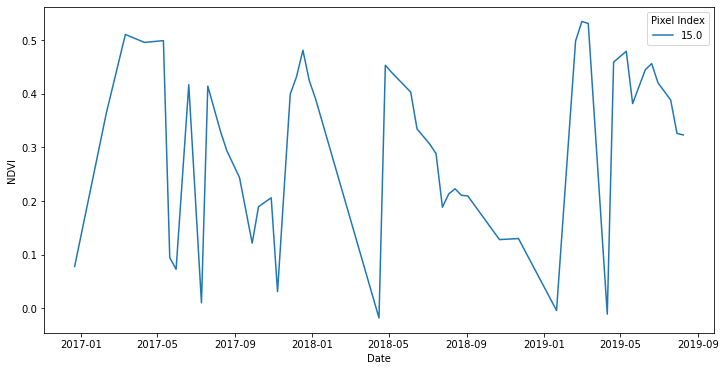

In [11]:
#split_by_pixels = split_by_pixels[split_by_pixels['NDVI']>0.1]
fig, ax = plt.subplots(figsize = (12,6))   
sns.lineplot(data=split_by_pixels, x="Date", y="NDVI", hue="Pixel Index", ax=ax)

In [12]:
split_by_pixels = split_by_pixels[(split_by_pixels['Date']>'2018-07-01') & (split_by_pixels['Date']<'2019-08-01')]
split_by_pixels.sort_values(by='Date', ascending=True, inplace=True)
split_by_pixels.reset_index(inplace=True)
bool_mask_inv = (bool_mask == False)

<ipython-input-12-47e0975f6693>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  split_by_pixels.sort_values(by='Date', ascending=True, inplace=True)


ValueError: num must be 1 <= num <= 16, not 17

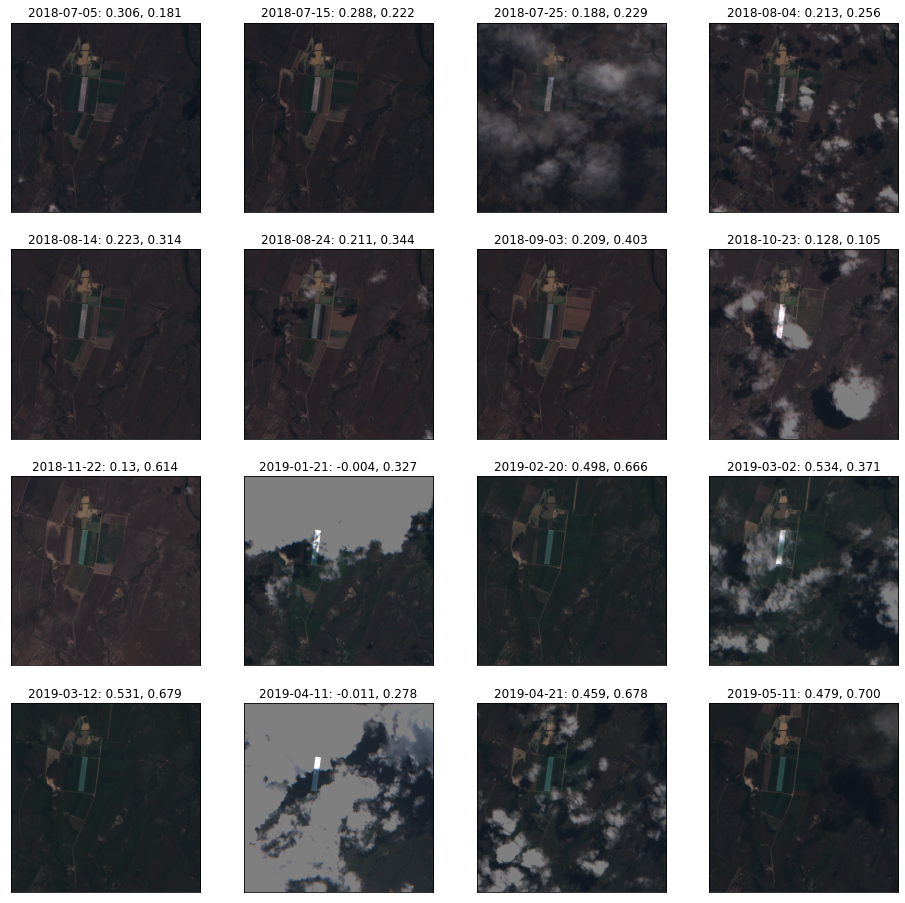

In [13]:
# Data exploration for detecting clouds
# Based on visualisation:
# "white" of cloud - colour intensity > 0.36
# "shadow" of cloud - 

w = 10
h = 10
fig = plt.figure(figsize=(16, 16))
columns = 4
rows = 4

# Cirrus_path = f"./satelite_data/Phase02DataDelivery/sugarcanetiles/{tile_x}-{tile_y}-B09-2019-07-20.png"

    
# for i in range(1,13):
#     ax = fig.add_subplot(rows, columns, i)
#     ax.set_xticks([])
#     ax.set_yticks([])
#     if(i == 9):
#         R_image = image.imread(f"./satelite_data/Phase02DataDelivery/sugarcanetiles/{tile_x}-{tile_y}-TCI-2019-07-20.png")
        
#         plt.imshow(R_image)
#     else:
#         R_image = image.imread(f"./satelite_data/Phase02DataDelivery/sugarcanetiles/{tile_x}-{tile_y}-B{i:02}-2019-07-20.png")
#         Cirrus_image = image.imread(Cirrus_path)
#         plt.imshow(np.minimum(np.maximum(norm_image(R_image)-0.475,0)*1000,1))


for index, row in split_by_pixels.iterrows():
    index = index+1
    ax = fig.add_subplot(rows, columns, index)
    ax.set_xticks([])
    ax.set_yticks([])
    str_date = row['Date'].strftime("%Y-%m-%d")
    TCI_image = image.imread(f"./satelite_data/Phase02DataDelivery/sugarcanetiles/{tile_x}-{tile_y}-TCI-{str_date}.png")
    NIR_path = f"./satelite_data/Phase02DataDelivery/sugarcanetiles/{tile_x}-{tile_y}-B08-{str_date}.png"
    R_path = f"./satelite_data/Phase02DataDelivery/sugarcanetiles/{tile_x}-{tile_y}-B04-{str_date}.png"
    NIR_image = image.imread(NIR_path)
    R_image = image.imread(R_path)
    NDVI_image = (NIR_image - R_image)/(NIR_image + R_image)
    
    first_x = int(first_index/512)
    first_y = int(first_index % 512)
    NDVI_image[bool_mask_inv] = 0
    
    mean_ndvi = (NDVI_image[bool_mask]).mean()
    ax.set_title(f"{str_date}: {round(row['NDVI'],3)}, {mean_ndvi:.3f}")
#     plt.imshow(NDVI_image)
    
    TCI_image[bool_mask_inv, 0] = TCI_image[bool_mask_inv, 0]/2
    TCI_image[bool_mask_inv, 1] = TCI_image[bool_mask_inv, 1]/2
    TCI_image[bool_mask_inv, 2] = TCI_image[bool_mask_inv, 2]/2
    plt.imshow(TCI_image)

In [ ]:
df['Time']

In [ ]:
def plot_index(index):
    w = 10
    h = 10
    fig = plt.figure(figsize=(8, 8))
    columns = 2
    rows = 2

    ax = fig.add_subplot(rows, columns, 1)
    ax.set_xticks([])
    ax.set_yticks([])
    ndvi_1 = copy.deepcopy(df["Image"][index])
    ndvi_1[bool_mask, 0] = 0
    ndvi_1[bool_mask, 1] = np.minimum(np.maximum(df["NDVI Image"][index][bool_mask],0),1)
    ndvi_1[bool_mask, 2] = 0
    plt.imshow(ndvi_1)

    ax = fig.add_subplot(rows, columns, 2)
    ax.set_xticks([])
    ax.set_yticks([])
    clouds = copy.deepcopy(df["Image"][index])
    vals = clouds[bool_mask, 0]
    vals[df["Cloud Cover"][index]>1] = 0
    clouds[bool_mask, 0] = vals
    vals = clouds[bool_mask, 1]
    vals[df["Cloud Cover"][index]>1] = 0
    clouds[bool_mask, 1] = vals
    vals = clouds[bool_mask, 2]
    vals[df["Cloud Cover"][index]>1] = 1
    clouds[bool_mask, 2] = vals
    plt.imshow(clouds)

    ax = fig.add_subplot(rows, columns, 3)
    ax.set_xticks([])
    ax.set_yticks([])
    ndvis = copy.deepcopy(df["Image"][index])
    ndvis[bool_mask, 0] = 0
    ndvis[bool_mask, 1] = np.minimum(np.maximum(0, df["NDVI Imputed"][index]), 1)
    ndvis[bool_mask, 2] = 0
    plt.imshow(ndvis)

    ax = fig.add_subplot(rows, columns, 4)
    ax.set_xticks([])
    ax.set_yticks([])
    maskz = copy.deepcopy(df["Image"][index])
    #maskz[bool_mask] = [0,1,0]
    plt.imshow(maskz)

    fig.suptitle('...', fontsize=14)
    plt.subplots_adjust(top=0.90)
    plt.show()
    
plot_index(66)

In [ ]:
plot_index(65)

In [ ]:
CropIndex = np.full((n,1), -1, dtype=int)
ravel_mask = bool_mask.reshape(n,1)
CropIndex[ravel_mask] = df["Crop Index"][9]
CropIndex = CropIndex+1
CropIndex = CropIndex.reshape(image_width, image_height, 1)
plt.imshow(CropIndex)

In [ ]:
image_file.shape

In [ ]:
CropIndex.shape

In [ ]:
mask_image.shape

In [ ]:
df.tail(3)

In [ ]:
img_z = (df["NDVI Image"][9]).reshape(512,512)
plt.imshow(img_z)

In [ ]:
img_z = (df["Image"][9]).reshape(512,512,3)
plt.imshow(img_z)

In [ ]:
img_z = np.maximum(df["Crop Index"][9].reshape(512,512),1)*255

In [ ]:
img_z = (np.minimum(df["Crop Index"][9],1)>=1).reshape(512,512)
plt.imshow(img_z)

In [ ]:
plt.imshow(df["Image"][9])

In [ ]:
df["Image"][0].save('timeseries.gif', save_all=True, append_images=df["Image"][1:], optimize=False, duration=2400, loop=0)

![timeseries.gif](./timeseries.gif)

In [ ]:
col_split = 255/crop_index.max()
images = []
for i in range(df["Crop Index"].shape[0]):
    color_vals = (df["Crop Index"][i]*col_split).reshape(image_width, image_height)
    im = Image.fromarray(np.uint8(cm.gist_earth(color_vals)))
    images.append(im)
    

images[0].save('cropindex.gif',
               save_all=True, append_images=images[1:], optimize=False, duration=40, loop=0)

In [ ]:
images[12]

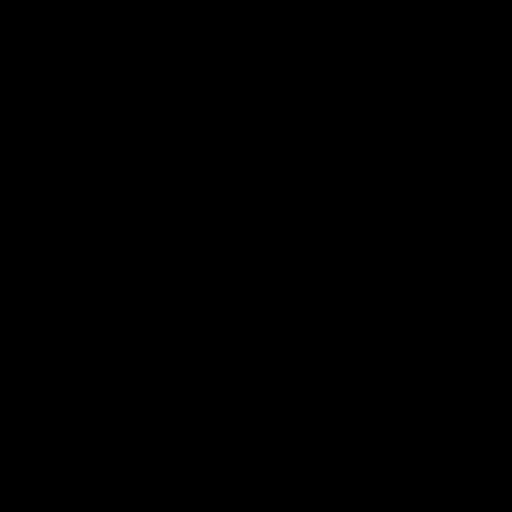